# Confidence Interval of Dissociation Constant
by
Bootstrapping of concentration series-based measurements of the molecular interaction according to Hill

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from resampling.bootstrap import Bootstrap
from resampling.hill import Hill

## Load data
Load data from File

In [2]:
sampleNumber = 100
seed = 42
date = 140716
fileName = "/home/malkusch/PowerFolders/Met-HMM/modeling/Data/191108_HMM_FCSdata_MET_InlB321-ATTO647N.xlsx"
print('Read data from %s\nAnalyze Experiment %i' %(fileName, date))

dfRaw = pd.read_excel(fileName,
                      index_col = None,
                      header=0,
                      sheet_name = "Tabelle1")
    
dfRaw = dfRaw[dfRaw["date"] == date]
dfRaw = dfRaw[dfRaw["MET [nM]"] > 0.0]
dfRaw = dfRaw.sort_values(by=['MET [nM]'])
dfRaw['tauD1/tauD0'] = dfRaw['tauD1'] / dfRaw['tauD0']
dfRaw['tauD2/tauD0'] = dfRaw['tauD2'] / dfRaw['tauD0']
dfRaw['tauD3/tauD0'] = dfRaw['tauD3'] / dfRaw['tauD0']
dfRaw.index = range(dfRaw.shape[0])
dfRaw

Read data from /home/malkusch/PowerFolders/Met-HMM/modeling/Data/191108_HMM_FCSdata_MET_InlB321-ATTO647N.xlsx
Analyze Experiment 140716


,date,MET [nM],tauD1,tauD2,tauD3,tauD0,tauD1/tauD0,tauD2/tauD0,tauD3/tauD0
0,140716,0.01,2.83250,2.49611,2.58492,2.48,1.142137,1.006496,1.042306
1,140716,0.10,2.62996,2.39351,2.35857,2.48,1.060468,0.965125,0.951036
2,140716,1.00,3.00012,2.77656,2.69345,2.48,1.209726,1.119581,1.086069
3,140716,2.00,3.06707,3.16165,2.90374,2.48,1.236722,1.274859,1.170863
4,140716,5.00,3.28574,3.33106,3.07903,2.48,1.324895,1.343169,1.241544
5,140716,10.00,3.89516,3.64520,3.75249,2.48,1.570629,1.469839,1.513101
6,140716,20.00,3.64382,3.72546,3.72534,2.48,1.469282,1.502202,1.502153
7,140716,50.00,3.90685,3.75857,3.61767,2.48,1.575343,1.515552,1.458738
8,140716,100.00,3.72830,3.55549,3.64403,2.48,1.503347,1.433665,1.469367
9,140716,1000.00,4.23432,3.89585,3.65247,2.48,1.707387,1.570907,1.472770


## Display NaN statistics

In [3]:
df_na = pd.DataFrame({'na count': dfRaw.isna().sum()})
df_na['na fraction'] = df_na['na count'] / dfRaw.shape[0]
df_na

,na count,na fraction
date,0,0.0
MET [nM],0,0.0
tauD1,0,0.0
tauD2,0,0.0
tauD3,0,0.0
tauD0,0,0.0
tauD1/tauD0,0,0.0
tauD2/tauD0,0,0.0
tauD3/tauD0,0,0.0


## Replace NaN
by mean of remaining

In [4]:
meanValues = dfRaw[['tauD1', 'tauD2', 'tauD3']].mean(axis=1)
dfRaw = dfRaw.T.fillna(value = meanValues).T
dfRaw['tauD1/tauD0'] = dfRaw['tauD1'] / dfRaw['tauD0']
dfRaw['tauD2/tauD0'] = dfRaw['tauD2'] / dfRaw['tauD0']
dfRaw['tauD3/tauD0'] = dfRaw['tauD3'] / dfRaw['tauD0']
dfRaw

,date,MET [nM],tauD1,tauD2,tauD3,tauD0,tauD1/tauD0,tauD2/tauD0,tauD3/tauD0
0,140716.0,0.01,2.83250,2.49611,2.58492,2.48,1.142137,1.006496,1.042306
1,140716.0,0.10,2.62996,2.39351,2.35857,2.48,1.060468,0.965125,0.951036
2,140716.0,1.00,3.00012,2.77656,2.69345,2.48,1.209726,1.119581,1.086069
3,140716.0,2.00,3.06707,3.16165,2.90374,2.48,1.236722,1.274859,1.170863
4,140716.0,5.00,3.28574,3.33106,3.07903,2.48,1.324895,1.343169,1.241544
5,140716.0,10.00,3.89516,3.64520,3.75249,2.48,1.570629,1.469839,1.513101
6,140716.0,20.00,3.64382,3.72546,3.72534,2.48,1.469282,1.502202,1.502153
7,140716.0,50.00,3.90685,3.75857,3.61767,2.48,1.575343,1.515552,1.458738
8,140716.0,100.00,3.72830,3.55549,3.64403,2.48,1.503347,1.433665,1.469367
9,140716.0,1000.00,4.23432,3.89585,3.65247,2.48,1.707387,1.570907,1.472770


## Resample with replacement

In [5]:
bs = Bootstrap()
bs.seed = seed
bs.data = dfRaw[['tauD1', 'tauD2', 'tauD3']].to_numpy()
rsData = np.zeros([dfRaw.shape[0], sampleNumber+1])
rsData[:,0] = dfRaw['MET [nM]'].to_numpy()
rsData[:,1:] = bs.resample(number = sampleNumber)
rsMessage = str('Generated %i concentration series by Monte Carlo powered Bootstrapping.\nSeed of random number generator is set to %i' %(sampleNumber, seed))
print(rsMessage)

Generated 100 concentration series by Monte Carlo powered Bootstrapping.
Seed of random number generator is set to 42


## Modeling
with Hill Equation

In [6]:
print('Init Model parameter:\ntauLigand = %.3f\nn= %i\ninitKd= %.3f\ninitTauComplex = %.3f' %(dfRaw['tauD0'].loc[0], 1, 5.0, 4.0))
modelLst = []
for i in range(sampleNumber):
    model = Hill()
    model.data = rsData[:,(0,i+1)]
    model.thetaLgnd = dfRaw['tauD0'].loc[0]
    model.n = 1
    model.initKd = 5.0
    model.initThetaCmplx = 4.0
    model.fitMLE()
    modelLst.append(model)
    
index = []
for i in range(sampleNumber):
    modelName = i #str('model_%i' %(i))
    index.append(modelName)
    
columns = ('fitSuccess', 'Kd', 'Ka', 'n', 'tauLigand', 'tauComplex', 'logL', 'BIC', 'AIC', 'AICc', 'rmse')
df_model = pd.DataFrame(index=index, columns=columns).fillna(value = 0.0)



for i in range(sampleNumber):
    df_model.loc[index[i]] = ({'fitSuccess': modelLst[i].fitSuccess,
                               'Kd': modelLst[i].kd,
                               'Ka': modelLst[i].ka,
                               'n': modelLst[i].n,
                               'tauLigand': modelLst[i].thetaLgnd,
                               'tauComplex': modelLst[i].thetaCmplx,
                               'logL': modelLst[i].logL,
                               'BIC': modelLst[i].bic,
                               'AIC': modelLst[i].aic,
                               'AICc': modelLst[i].aicc,
                               'rmse': modelLst[i].rmse})
    
df_model = df_model.astype({'fitSuccess': 'bool',
                            'Kd': 'float64',
                            'Ka': 'float64',
                            'n': 'int32',
                            'tauLigand': 'float64',
                            'tauComplex': 'float64',
                            'logL': 'float64',
                            'BIC': 'float64',
                            'AIC': 'float64',
                            'AICc': 'float64',
                            'rmse': 'float64'})                               
    
df_model

Init Model parameter:
tauLigand = 2.480
n= 1
initKd= 5.000
initTauComplex = 4.000


,fitSuccess,Kd,Ka,n,tauLigand,tauComplex,logL,BIC,AIC,AICc,rmse
0,True,2.003573,2.003573,1,2.48,3.680976,7.291122,-9.977074,-10.582245,-8.867959,0.114415
1,True,3.154793,3.154793,1,2.48,3.884799,-6.331271,17.267712,16.662542,18.376828,0.200837
2,True,2.679325,2.679325,1,2.48,3.824437,0.446040,3.713089,3.107919,4.822205,0.163649
3,True,4.373283,4.373283,1,2.48,3.977382,-0.873994,6.353159,5.747989,7.462274,0.171525
4,True,2.081469,2.081469,1,2.48,3.753246,-3.289686,11.184541,10.579371,12.293657,0.185074
...,...,...,...,...,...,...,...,...,...,...,...
95,True,2.303181,2.303181,1,2.48,3.866574,-3.151410,10.907990,10.302820,12.017105,0.184325
96,True,2.640471,2.640471,1,2.48,3.900033,2.990762,-1.376354,-1.981524,-0.267239,0.147280
97,True,2.533185,2.533185,1,2.48,3.761532,0.571374,3.462422,2.857252,4.571538,0.162881
98,True,2.416162,2.416162,1,2.48,3.711396,0.579398,3.446374,2.841203,4.555489,0.162832


## Plot Model

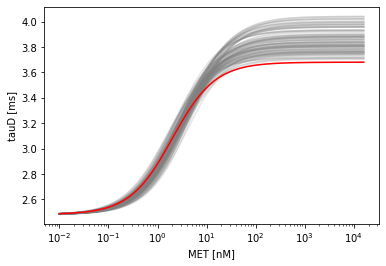

In [7]:
cLig = np.arange(0.01, 16000, 0.01)
for i in range(sampleNumber):
    plt.plot(cLig, modelLst[i].predict(cLig), c='grey', alpha=0.2)
    
plt.plot(cLig, modelLst[0].predict(cLig), c='red')

plt.xscale(value = 'log')
plt.xlabel(xlabel = 'MET [nM]')
plt.ylabel(ylabel = 'tauD [ms]')
plt.show()

## Kd distribution

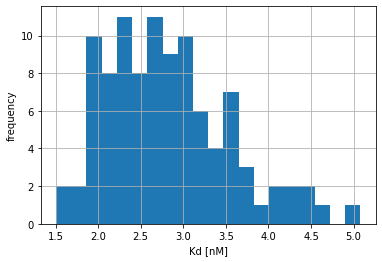

In [8]:
df_model['Kd'].hist(bins = 20)
plt.xlabel(xlabel = 'Kd [nM]')
plt.ylabel(ylabel = 'frequency')
plt.show()

## Model Statistics

In [9]:
df_model.describe()

,Kd,Ka,n,tauLigand,tauComplex,logL,BIC,AIC,AICc,rmse
count,100.000000,100.000000,100.0,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.814325,2.814325,1.0,2.480000e+00,3.853081,1.002009,2.601153,1.995983,3.710268,0.157461
std,0.723317,0.723317,0.0,4.463264e-15,0.092974,4.745529,9.491058,9.491058,9.491058,0.029729
min,1.505998,1.505998,1.0,2.480000e+00,3.680976,-13.210723,-13.981891,-14.587061,-12.872775,0.095320
25%,2.253387,2.253387,1.0,2.480000e+00,3.776598,-2.397948,-4.320207,-4.925377,-3.211091,0.136922
50%,2.713420,2.713420,1.0,2.480000e+00,3.839978,1.585568,1.434035,0.828865,2.543150,0.156530
75%,3.256890,3.256890,1.0,2.480000e+00,3.927306,4.462689,9.401066,8.795896,10.510182,0.180189
max,5.079712,5.079712,1.0,2.480000e+00,4.042203,9.293530,31.026616,30.421445,32.135731,0.232582


## Save Results

In [10]:
rawFileName = str('/home/malkusch/PowerFolders/Met-HMM/modeling/Data/rawData_%i.csv' %(date))
dfRaw.to_csv(path_or_buf = rawFileName, index = False)
print('Wrote raw data to %s' %(rawFileName))
modelFileName = str('/home/malkusch/PowerFolders/Met-HMM/modeling/Data/FCS_Model_%i.csv' %(date))
df_model.to_csv(path_or_buf = modelFileName, index = True)
print('Wrote model to %s' %(modelFileName))

Wrote raw data to /home/malkusch/PowerFolders/Met-HMM/modeling/Data/rawData_140716.csv
Wrote model to /home/malkusch/PowerFolders/Met-HMM/modeling/Data/FCS_Model_140716.csv
